In [29]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(1, '../scripts')

from ellipse import *

import pandas as pd
import numpy as np
import vg
import matplotlib.pyplot as plt
plt.style.use('notebook')
from scipy.signal import find_peaks




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Characterization of Orbits

In offshore wind turbine vibrations, orbits can be observed. The goal is to develop a scalar metric (or possibly many) with which the orbits can be characterized. 


For different phase angles, the shape of the orbit changes from a circle ($\pm \pi/2$) to an ellipse ($\pi < \phi < \pi/2$) to a single line ($\pi$)

Using an ellipse to characterize orbits seems to be the simplest approach. Ellipses are described by their semi-major axis $a$, their semi-minor axis $b$ from which the eccentricity $c$ and linear eccentricity $e$ can be calculated:

Linear eccentricity
This is the distance from the center to a focus: 

$$
c = {\sqrt {a^{2}-b^{2}}}
$$

$$
e = \frac {c}{a} = {\sqrt {1-\left({\frac {b}{a}}\right)^{2}}}
$$

![Ellipse Shape Parameters](ellipse.png)

Of interest here are two factors: the direction of the orbit (in case of a perfect circle, no main direction can be determined) and the eccentricity of the ellipse. Different possibilities exist to calculate (geometrically) or estimate (statistically) these parameters. In the following, a simple geometrical approach is chosen:
1. calculate the deflection
2. find the deflection maxima and minima
3. combining each consecutive maxima yields a new temporal signal corresponding to the amplitude envelope
4. combining each consecutive minimum yields a new tempoeral signal for the smallest distance between the orbit trajectory and the center
5. from the ratio of the two temporal signals the eccentricity of the ellipse can be obtained
6. the main direction of the orbit can be calculated using vector algebra

Here follows an example for $\phi = \pi/8$

In [30]:
f = 0.25
num_periods = 30
signal_duration = num_periods/f
delta_t = 0.03
omega = 2 * np.pi * f
A_x = 1
A_y = 1
phi_x = 0.1*np.pi
phi_y = 0

t = np.linspace(0, signal_duration, int(signal_duration/delta_t))
x = A_x * np.sin(omega*t + phi_x)
y = A_y * np.sin(omega*t + phi_y)

<IPython.core.display.Javascript object>


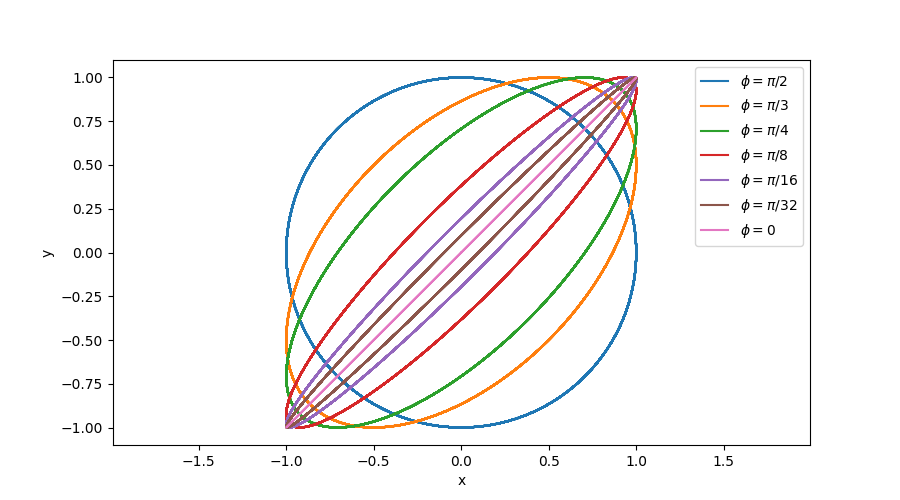

Text(0, 0.5, 'y')

In [31]:
plt.figure()
plt.plot(np.sin(omega*t + np.pi/2), np.sin(omega*t), label='$\phi = \pi/2$')
plt.plot(np.sin(omega*t + np.pi/3), np.sin(omega*t), label='$\phi = \pi/3$')
plt.plot(np.sin(omega*t + np.pi/4), np.sin(omega*t), label='$\phi = \pi/4$')
plt.plot(np.sin(omega*t + np.pi/8), np.sin(omega*t), label='$\phi = \pi/8$')
plt.plot(np.sin(omega*t + np.pi/16), np.sin(omega*t), label='$\phi = \pi/16$')
plt.plot(np.sin(omega*t + np.pi/32), np.sin(omega*t), label='$\phi = \pi/32$')
plt.plot(np.sin(omega*t), np.sin(omega*t), label='$\phi = 0$')
plt.axis('equal')
plt.legend(loc='upper right')
plt.xlabel('x')
plt.ylabel('y')

## Derive ellipse shape parameters from a harmonic signal

Let us start with two simple signals, describing a harmonic motion in the x- and y-direction:


$$x(t) = A_{x} sin(\omega t + \phi_{x})$$
$$y(t) = A_{y} sin(\omega t + \phi_{y})$$

Where $\omega = 2\pi f$ with $f = 0.25$ $s^{-1}$. This means,the frequencies in both directions are equal

Now, we have aqcuired two temporal, harmonic signals with identical amplitudes, a phase shift of 90 degrees and a constant frequency

<IPython.core.display.Javascript object>


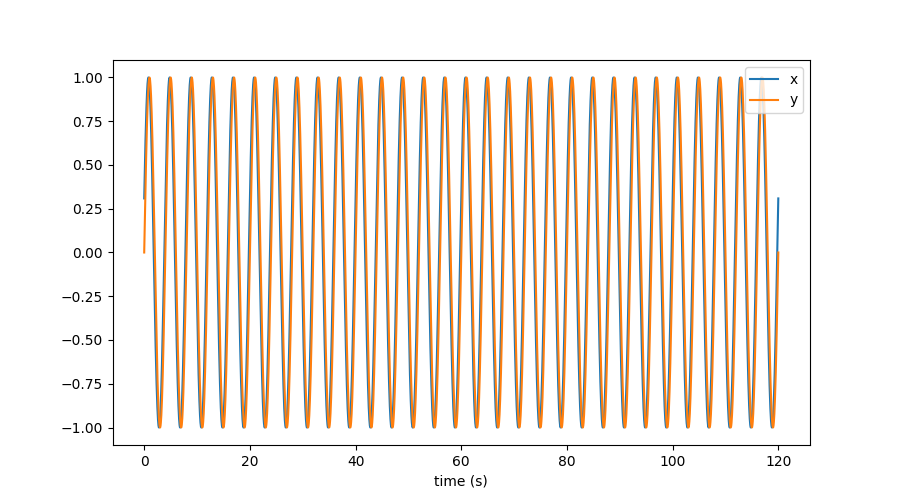

Text(0.5, 0, 'time (s)')

In [32]:
plt.figure()
plt.plot(t, x, label='x')
plt.plot(t, y, label='y')
plt.legend(loc='upper right')
plt.xlabel('time (s)')

plotting the two signals as a lissajous-figure ($x(t) = f(y(t))$ yields an orbit

<IPython.core.display.Javascript object>


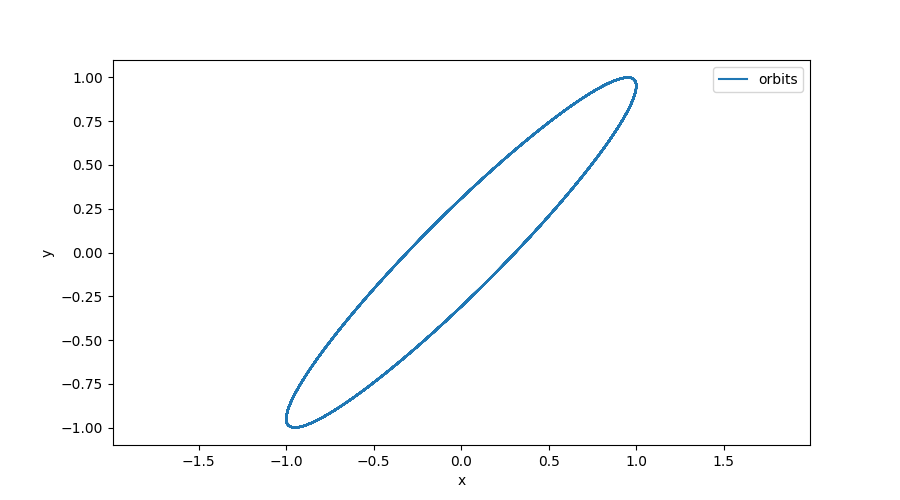

Text(0, 0.5, 'y')

In [33]:
plt.figure()
plt.plot(x, y, label='orbits')
plt.axis('equal')
plt.legend(loc='upper right')
plt.xlabel('x')
plt.ylabel('y')

<IPython.core.display.Javascript object>


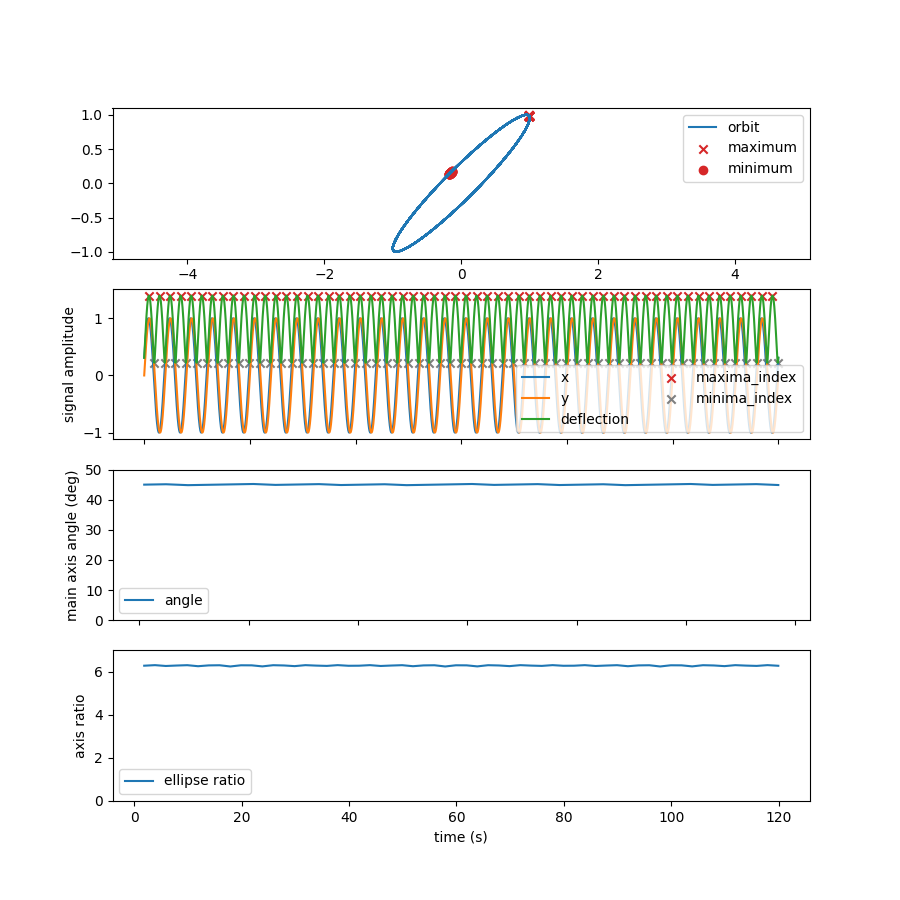

Text(0, 0.5, 'axis ratio')

In [76]:
deflection = calc_deflection(x, y)
max_deflection_i, max_deflection_t, max_deflection = find_max_deflection(t, deflection)
min_deflection_i, min_deflection_t, min_deflection = find_min_deflection(t, deflection)
max_deflection_angles_t, max_deflection_angles = calc_max_deflection_angles(t, max_deflection_i, x, y)
ratio_t, ratio = calc_axis_ratio(min_deflection_t, min_deflection, max_deflection_t, max_deflection)


_, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=1, nrows=4, figsize=(9, 9)) 
ax1.plot(x, y, label='orbit')
ax1.scatter(x[max_deflection_i[::2]], y[max_deflection_i[::2]], label='maximum', marker='x', color='tab:red')
ax1.scatter(x[min_deflection_i[::2]], y[min_deflection_i[::2]], label='minimum', marker='o', color='tab:red')
ax1.axis('equal')
ax1.legend()

ax2.plot(t, x, label='x')
ax2.plot(t, y, label='y')
ax2.plot(t, deflection, label='deflection')

ax2.scatter(t[max_deflection_i], deflection[max_deflection_i], marker='x', color='tab:red', label='maxima_index')
ax2.scatter(t[min_deflection_i], deflection[min_deflection_i], marker='x', color='tab:grey', label='minima_index')
ax2.legend(loc='lower right', ncol=2)
ax2.set_ylabel('signal amplitude')
ax2.set_xticklabels([])

ax3.plot(max_deflection_angles_t, max_deflection_angles, label='angle')
ax3.set_ylim([0,50])
ax3.set_ylabel('main axis angle (deg)')
ax3.legend()
ax3.set_xticklabels([])


ax4.plot(ratio_t, ratio, label='ellipse ratio')
ax4.set_ylim(0, 7)
ax4.legend()
ax4.set_xlabel('time (s)')
ax4.set_ylabel('axis ratio')

## Signal with a varying amplitude

In [63]:
A_x = 0.5 + 0.1 * np.sin(0.1 * omega * t)
A_y = 1
phi = np.pi/5
xx = A_x * np.sin(omega*t)
yy = A_y * np.sin(omega*t + phi)

In [74]:
deflection = calc_deflection(xx, yy)
max_deflection_i, max_deflection_t, max_deflection = find_max_deflection(t, deflection)
min_deflection_i, min_deflection_t, min_deflection = find_min_deflection(t, deflection)
max_deflection_angles_t, max_deflection_angles = calc_max_deflection_angles(t, max_deflection_i, xx, yy)
ratio_t, ratio = calc_axis_ratio(min_deflection_t=min_deflection_t,
                                 min_deflection=min_deflection,
                                 max_deflection_t=max_deflection_t,
                                 max_deflection=max_deflection,
                                )

<IPython.core.display.Javascript object>


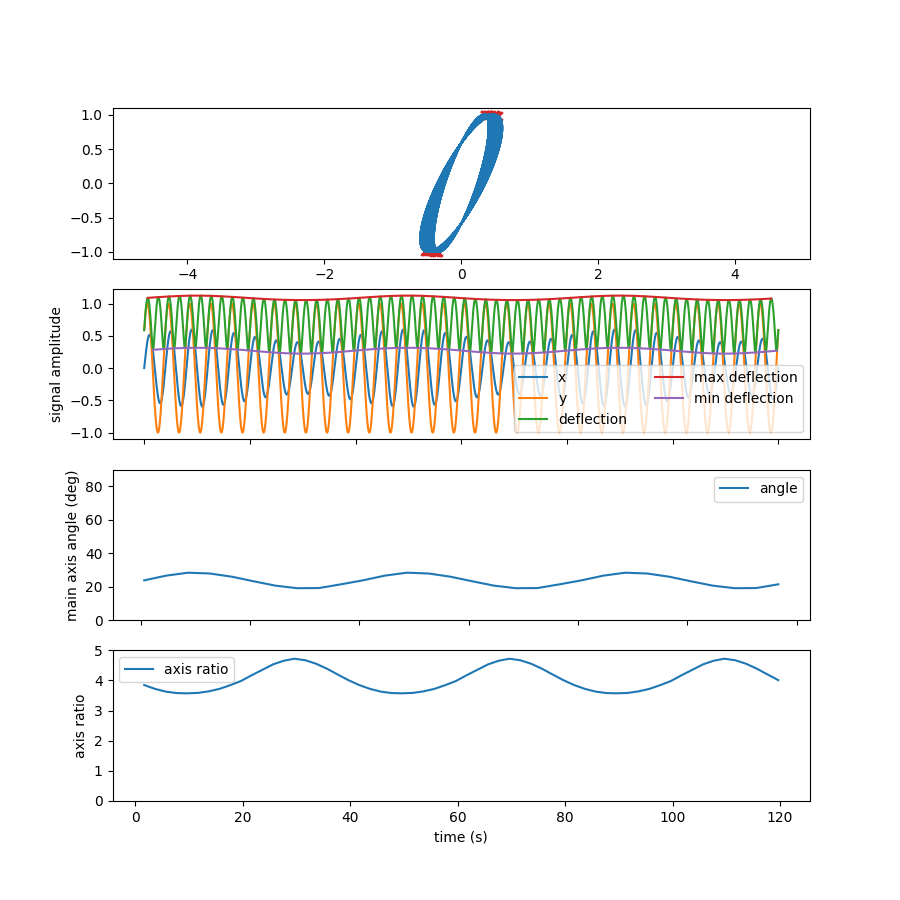

Text(0, 0.5, 'axis ratio')

In [75]:
_, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=1, nrows=4, figsize=(9,9))

ax1.plot(xx, yy, label='orbit')
ax1.scatter(xx[max_deflection_i], yy[max_deflection_i], marker='x', color='tab:red')
ax1.axis('equal')

ax2.plot(t, xx, label='x')
ax2.plot(t, yy, label='y')
ax2.plot(t, deflection, label='deflection')
ax2.plot(max_deflection_t, max_deflection, label='max deflection')
ax2.plot(min_deflection_t, min_deflection, label='min deflection')
ax2.legend(loc='lower right', ncol=2)
ax2.set_ylabel('signal amplitude')
ax2.set_xticklabels([])

ax3.plot(max_deflection_angles_t, max_deflection_angles, label='angle')
ax3.set_ylabel('main axis angle (deg)')
ax3.legend()
ax3.set_ylim([0, 90])
ax3.set_xticklabels([])
    
ax4.plot(ratio_t, ratio, label='axis ratio')
ax4.legend()
ax4.set_ylim([0, 5])
ax4.set_xlabel('time (s)')
ax4.set_ylabel('axis ratio')